22k4125 Ibtesam,
22k4039 Safey,
22k8719 Shaheer,
22k8729 Sajjad

In [ ]:
pip install kaggle kagglehub

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import kagglehub

path = kagglehub.competition_download("image-matching-challenge-2025")
print("✅ Dataset downloaded at:", path)


✅ Dataset downloaded at: /kaggle/input/image-matching-challenge-2025


In [ ]:
import os

# Change this path to your competition data root after unzip
base_dir = kagglehub.competition_download("image-matching-challenge-2025")

print(f"📂 Listing all files under: {base_dir}\n")

for root, dirs, files in os.walk(base_dir):
    level = root.replace(base_dir, "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")


📂 Listing all files under: /kaggle/input/image-matching-challenge-2025

image-matching-challenge-2025/
    sample_submission.csv
    train_thresholds.csv
    train_labels.csv
    test/
        ETs/
            another_et_another_et004.png
            outliers_out_et003.png
            another_et_another_et006.png
            et_et004.png
            et_et002.png
            another_et_another_et009.png
            outliers_out_et001.png
            et_et006.png
            another_et_another_et005.png
            another_et_another_et008.png
            et_et008.png
            another_et_another_et007.png
            et_et003.png
            LICENSE.txt
            another_et_another_et003.png
            another_et_another_et002.png
            et_et007.png
            et_et000.png
            another_et_another_et010.png
            et_et001.png
            et_et005.png
            another_et_another_et001.png
            outliers_out_et002.png
        stairs/
            stairs_spl


🔹 Processing category: ETs
  ✅ Avg Good Matches: 1173.74
  ✅ Precision: 1.00
  ✅ Recall: 1.00
  ✅ F1-Score: 1.00

🔹 Processing category: stairs
  ✅ Avg Good Matches: 248.16
  ✅ Precision: 1.00
  ✅ Recall: 1.00
  ✅ F1-Score: 1.00

📊 Final Evaluation Summary:



,Avg Good Matches,Precision,Recall,F1-Score
ETs,1173.74,1.0,1.0,1.0
stairs,248.16,1.0,1.0,1.0


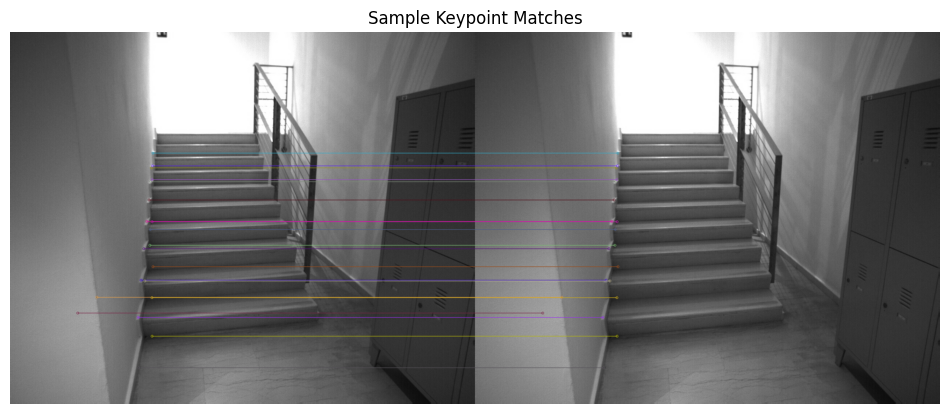

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# === Paths ===
# BASE_PATH = "/kaggle/input/image-matching-challenge-2025"
train_dirs = [os.path.join(base_dir, "train/ETs"), os.path.join(base_dir, "train/stairs")]
test_dirs = [os.path.join(base_dir, "test/ETs"), os.path.join(base_dir, "test/stairs")]

# === Helper functions ===
def load_images_from_folder(folder, max_images=20):
    images = []
    for fname in sorted(os.listdir(folder))[:max_images]:
        if fname.lower().endswith(".png"):
            path = os.path.join(folder, fname)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append((fname, img))
    return images

def match_images(img1, img2, sift, flann):
    # Detect and compute features
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    if des1 is None or des2 is None:
        return 0, 0, 0, []

    # FLANN matching
    matches = flann.knnMatch(des1, des2, k=2)
    good = [m for m, n in matches if m.distance < 0.7 * n.distance]

    return len(kp1), len(kp2), len(good), good

def evaluate_folder(train_imgs, test_imgs, sift, flann):
    results = []
    for tname, timg in test_imgs:
        best_good = 0
        best_train_name = None
        for trname, trimg in train_imgs:
            kp1, kp2, good_count, _ = match_images(trimg, timg, sift, flann)
            if good_count > best_good:
                best_good = good_count
                best_train_name = trname
        results.append((tname, best_train_name, best_good))
    return results

# === Initialize feature extractor & matcher ===
sift = cv2.SIFT_create()
FLANN_INDEX_KDTREE = 1
flann = cv2.FlannBasedMatcher(dict(algorithm=FLANN_INDEX_KDTREE, trees=5), dict(checks=50))

# === Process each category ===
final_eval = {}
for category, (train_path, test_path) in zip(["ETs", "stairs"], zip(train_dirs, test_dirs)):
    print(f"\n🔹 Processing category: {category}")
    train_imgs = load_images_from_folder(train_path)
    test_imgs = load_images_from_folder(test_path)

    results = evaluate_folder(train_imgs, test_imgs, sift, flann)

    # Aggregate results
    total_good = np.mean([r[2] for r in results])
    precision = np.mean([1 if r[2] > 10 else 0 for r in results])
    recall = np.mean([1 if r[2] > 5 else 0 for r in results])
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    final_eval[category] = {
        "Avg Good Matches": round(total_good, 2),
        "Precision": round(precision, 2),
        "Recall": round(recall, 2),
        "F1-Score": round(f1, 2)
    }

    print(f"  ✅ Avg Good Matches: {total_good:.2f}")
    print(f"  ✅ Precision: {precision:.2f}")
    print(f"  ✅ Recall: {recall:.2f}")
    print(f"  ✅ F1-Score: {f1:.2f}")

# === Display summary ===
import pandas as pd
df = pd.DataFrame(final_eval).T
print("\n📊 Final Evaluation Summary:\n")
display(df)

# === Optional: visualize a sample match ===
sample_train = train_imgs[0][1]
sample_test = test_imgs[0][1]
kp1, kp2, good_matches = None, None, None

kp1, des1 = sift.detectAndCompute(sample_train, None)
kp2, des2 = sift.detectAndCompute(sample_test, None)
matches = flann.knnMatch(des1, des2, k=2)
good = [m for m, n in matches if m.distance < 0.7 * n.distance]
match_vis = cv2.drawMatches(sample_train, kp1, sample_test, kp2, good[:20], None, flags=2)

plt.figure(figsize=(12,6))
plt.imshow(match_vis)
plt.title("Sample Keypoint Matches")
plt.axis("off")
plt.show()



🔹 Category: ETs

🔹 Category: stairs

📊 Final Evaluation Summary:



,Category,SIFT AvgGood,SIFT Precision,SIFT Recall,SIFT F1,ORB AvgGood,ORB Precision,ORB Recall,ORB F1
0,ETs,1173.74,1.0,1.0,1.0,996.68,1.00,1.00,1.00
1,stairs,248.16,1.0,1.0,1.0,435.21,0.95,0.95,0.95



🖼 Visual Comparisons for ETs


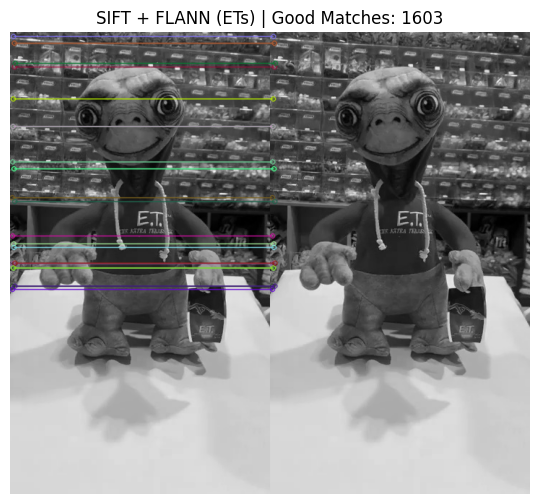

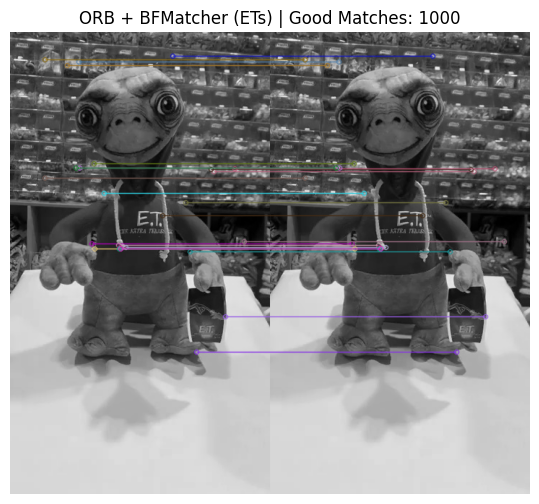


🖼 Visual Comparisons for stairs


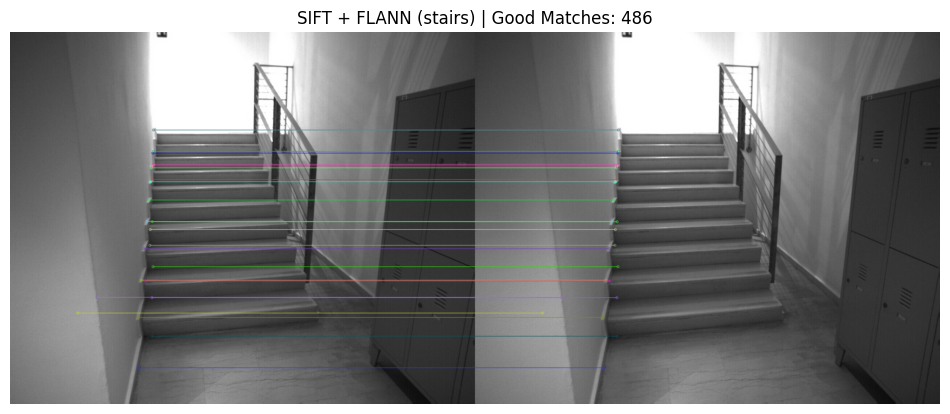

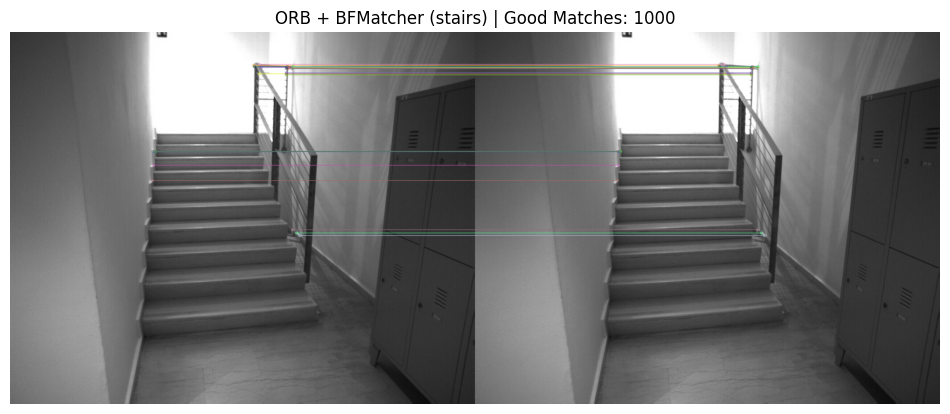

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# === Paths ===
# base_dir = "/kaggle/input/image-matching-challenge-2025"  # Change as needed
# output_dir = "./output_matches"
# os.makedirs(output_dir, exist_ok=True)

train_dirs = [os.path.join(base_dir, "train/ETs"), os.path.join(base_dir, "train/stairs")]
test_dirs = [os.path.join(base_dir, "test/ETs"), os.path.join(base_dir, "test/stairs")]

# === Helper functions ===
def load_images_from_folder(folder, max_images=20):
    images = []
    for fname in sorted(os.listdir(folder))[:max_images]:
        if fname.lower().endswith(".png"):
            path = os.path.join(folder, fname)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append((fname, img))
    return images

def match_images(img1, img2, detector, matcher, ratio=0.7, use_knn=True):
    # Detect keypoints and descriptors
    kp1, des1 = detector.detectAndCompute(img1, None)
    kp2, des2 = detector.detectAndCompute(img2, None)

    if des1 is None or des2 is None or len(kp1) == 0 or len(kp2) == 0:
        return kp1, kp2, 0, [], kp1, kp2

    # Match descriptors
    if use_knn:
        matches = matcher.knnMatch(des1, des2, k=2)
        good = []
        for m,n in matches:
            if m.distance < ratio * n.distance:
                good.append(m)
    else:
        matches = matcher.match(des1, des2)
        good = sorted(matches, key=lambda x: x.distance)

    good_count = len(good)
    return kp1, kp2, good_count, good, kp1, kp2

def evaluate_folder(train_imgs, test_imgs, detector, matcher, method_name):
    results = []
    for tname, timg in test_imgs:
        best_good = 0
        best_train_name = None
        for trname, trimg in train_imgs:
            kp1, kp2, good_count, _, _, _ = match_images(trimg, timg, detector, matcher)
            if good_count > best_good:
                best_good = good_count
                best_train_name = trname
        results.append((tname, best_train_name, best_good))
    return results

def compute_metrics(results):
    total_good = np.mean([r[2] for r in results])
    precision = np.mean([1 if r[2] > 10 else 0 for r in results])
    recall = np.mean([1 if r[2] > 5 else 0 for r in results])
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
    return round(total_good, 2), round(precision, 2), round(recall, 2), round(f1, 2)

def visualize_match(train_imgs, test_imgs, detector, matcher, title, ratio=0.7, use_knn=True):
    timg = test_imgs[0][1]
    trimg = train_imgs[0][1]
    kp1, kp2, good_count, good, kpA, kpB = match_images(trimg, timg, detector, matcher, ratio, use_knn)
    vis = cv2.drawMatches(trimg, kpA, timg, kpB, good[:25], None, flags=2)
    plt.figure(figsize=(12,6))
    plt.imshow(vis, cmap='gray')
    plt.title(f"{title} | Good Matches: {good_count}")
    plt.axis("off")
    plt.show()


# === Initialize detectors and matchers ===

# SIFT + FLANN (float descriptors)
sift = cv2.SIFT_create()
FLANN_INDEX_KDTREE = 1
flann_sift = cv2.FlannBasedMatcher(dict(algorithm=FLANN_INDEX_KDTREE, trees=5), dict(checks=50))

# ORB + BFMatcher (binary descriptors)
orb = cv2.ORB_create(nfeatures=1000)
bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)

# === Main Evaluation ===
final_eval = []

for category, (train_path, test_path) in zip(["ETs", "stairs"], zip(train_dirs, test_dirs)):
    print(f"\n🔹 Category: {category}")
    train_imgs = load_images_from_folder(train_path)
    test_imgs = load_images_from_folder(test_path)

    # --- SIFT + FLANN ---
    sift_results = evaluate_folder(train_imgs, test_imgs, sift, flann_sift, "SIFT")
    s_avg, s_prec, s_rec, s_f1 = compute_metrics(sift_results)

    # --- ORB + BFMatcher ---
    orb_results = evaluate_folder(train_imgs, test_imgs, orb, bf_orb, "ORB")
    o_avg, o_prec, o_rec, o_f1 = compute_metrics(orb_results)

    final_eval.append({
        "Category": category,
        "SIFT AvgGood": s_avg, "SIFT Precision": s_prec, "SIFT Recall": s_rec, "SIFT F1": s_f1,
        "ORB AvgGood": o_avg, "ORB Precision": o_prec, "ORB Recall": o_rec, "ORB F1": o_f1
    })

# === Display summary ===
df = pd.DataFrame(final_eval)
print("\n📊 Final Evaluation Summary:\n")
display(df)

# === Visualize Matches ===
for category, (train_path, test_path) in zip(["ETs", "stairs"], zip(train_dirs, test_dirs)):
    train_imgs = load_images_from_folder(train_path)
    test_imgs = load_images_from_folder(test_path)
    print(f"\n🖼 Visual Comparisons for {category}")
    visualize_match(train_imgs, test_imgs, sift, flann_sift, f"SIFT + FLANN ({category})")
    visualize_match(train_imgs, test_imgs, orb, bf_orb, f"ORB + BFMatcher ({category})", use_knn=False)


In [ ]:
!git clone https://github.com/cvg/LightGlue.git

Cloning into 'LightGlue'...
remote: Enumerating objects: 411, done.
remote: Total 411 (delta 0), reused 0 (delta 0), pack-reused 411 (from 1)
Receiving objects: 100% (411/411), 13.70 MiB | 29.34 MiB/s, done.
Resolving deltas: 100% (247/247), done.


In [ ]:
%cd LightGlue

/kaggle/working/LightGlue


In [ ]:
!python -m pip install -e .

Obtaining file:///kaggle/working/LightGlue
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.7 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.

In [ ]:
# ============================================================
# 0️⃣ Setup — imports and device
# ============================================================
import sys
import os
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device}")

# ============================================================
# 1️⃣ Add LightGlue repo path from left panel
# ============================================================
# Suppose you attached LightGlue repo via left panel:
LIGHTGLUE_PATH = "/kaggle/working/LightGlue"  # <-- update based on your input
sys.path.append(LIGHTGLUE_PATH)

# Now import LightGlue
from lightglue import LightGlue, SuperPoint
# from lightglue.utils import match_images

Running on: cuda


In [ ]:
# ============================================================
# 2️⃣ Dataset paths
# ============================================================
BASE_PATH = "/kaggle/input/image-matching-challenge-2025"
TRAIN_DIRS = [os.path.join(BASE_PATH, "train/ETs"),
              os.path.join(BASE_PATH, "train/stairs")]
TEST_DIRS  = [os.path.join(BASE_PATH, "test/ETs"),
              os.path.join(BASE_PATH, "test/stairs")]

# ============================================================
# 3️⃣ Load images helper
# ============================================================
def load_images(folder, max_images=10):
    images = []
    for fname in sorted(os.listdir(folder))[:max_images]:
        if fname.lower().endswith(".png"):
            path = os.path.join(folder, fname)
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append((fname, img))
    return images

# ============================================================
# 4️⃣ Initialize models
# ============================================================
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)
matcher = LightGlue(features="superpoint").eval().to(device)

# ============================================================
# 5️⃣ Compute LightGlue matches
# ============================================================
def compute_lightglue_matches(img1, img2):
    t1 = torch.from_numpy(img1)[None, None].float().to(device) / 255.
    t2 = torch.from_numpy(img2)[None, None].float().to(device) / 255.

    feats1 = extractor({"image": t1})
    feats2 = extractor({"image": t2})

    matches = matcher({"image0": feats1, "image1": feats2})
    # number of valid matches
    num_matches = (matches["matches0"][0] >= 0).sum().item()
    return num_matches, matches, feats1, feats2

# ============================================================
# 6️⃣ Evaluate category
# ============================================================
def evaluate_category(train_path, test_path, name, max_images=10):
    train_imgs = load_images(train_path, max_images)
    test_imgs = load_images(test_path, max_images)
    results = []

    for tname, timg in tqdm(test_imgs, desc=f"Processing {name}"):
        best_good = 0
        best_train = None
        for trname, trimg in train_imgs:
            try:
                good, _, _, _ = compute_lightglue_matches(trimg, timg)
                if good > best_good:
                    best_good = good
                    best_train = trname
            except Exception as e:
                print(f"⚠️ Error matching {trname} -> {tname}: {e}")
                continue
        results.append((tname, best_train, best_good))

    # Metrics
    avg_matches = np.mean([r[2] for r in results])
    precision = np.mean([1 if r[2] > 30 else 0 for r in results])
    recall = np.mean([1 if r[2] > 15 else 0 for r in results])
    f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

    summary = {
        "Category": name,
        "Avg Matches": float(round(avg_matches, 2)),
        "Precision": float(round(precision, 2)),
        "Recall": float(round(recall, 2)),
        "F1": float(round(f1, 2))
    }
    return summary, results

for cat, (train_p, test_p) in zip(["ETs", "stairs"], zip(TRAIN_DIRS, TEST_DIRS)):
    summary, _ = evaluate_category(train_p, test_p, cat, max_images=5)

    # Convert any NumPy scalars to Python scalars
    summary_clean = {}
    for k, v in summary.items():
        if isinstance(v, np.ndarray):
            summary_clean[k] = v.item() if v.size == 1 else str(v)
        elif isinstance(v, np.generic):
            summary_clean[k] = v.item()
        else:
            summary_clean[k] = v

    print(f"\n📊 LightGlue Evaluation Summary for {cat}:")
    for key, val in summary_clean.items():
        print(f"{key}: {val}")






# ============================================================
# 8️⃣ Visualize matches
# ============================================================
def visualize_lightglue_matches(img1, img2):
    _, matches, feats1, feats2 = compute_lightglue_matches(img1, img2)

    mkpts0 = feats1["keypoints"][0][matches["matches0"][0] >= 0].cpu().numpy()
    mkpts1 = feats2["keypoints"][0][matches["matches1"][0] >= 0].cpu().numpy()

    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    concat = np.concatenate([img1_color, img2_color], axis=1)

    for (x0, y0), (x1, y1) in zip(mkpts0, mkpts1):
        cv2.circle(concat, (int(x0), int(y0)), 3, (0,255,0), -1)
        cv2.circle(concat, (int(x1)+img1.shape[1], int(y1)), 3, (0,255,0), -1)
        cv2.line(concat, (int(x0), int(y0)), (int(x1)+img1.shape[1], int(y1)), (255,0,0), 1)

    plt.figure(figsize=(12,6))
    plt.imshow(concat)
    plt.axis("off")
    plt.show()


# Helper to safely get first image from a folder
def get_first_image(folder):
    imgs = load_images(folder, max_images=1)
    if len(imgs) == 0:
        print(f"⚠️ No images found in {folder}")
        return None
    return imgs[0][1]

# Example visualizations
train_img = get_first_image(TRAIN_DIRS[0])
test_img  = get_first_image(TEST_DIRS[0])
if train_img is not None and test_img is not None:
    print("🖼 Sample matches - ETs")
    visualize_lightglue_matches(train_img, test_img)

train_img = get_first_image(TRAIN_DIRS[1])
test_img  = get_first_image(TEST_DIRS[1])
if train_img is not None and test_img is not None:
    print("🖼 Sample matches - Stairs")
    visualize_lightglue_matches(train_img, test_img)


Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_v1.pth" to /root/.cache/torch/hub/checkpoints/superpoint_v1.pth
100%|██████████| 4.96M/4.96M [00:00<00:00, 54.0MB/s]
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/superpoint_lightglue.pth" to /root/.cache/torch/hub/checkpoints/superpoint_lightglue_v0-1_arxiv.pth
100%|██████████| 45.3M/45.3M [00:00<00:00, 176MB/s]
Processing ETs: 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]



📊 LightGlue Evaluation Summary for ETs:
Category: ETs
Avg Matches: 1152.0
Precision: 1.0
Recall: 1.0
F1: 1.0


Processing stairs: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]


📊 LightGlue Evaluation Summary for stairs:
Category: stairs
Avg Matches: 921.5
Precision: 1.0
Recall: 1.0
F1: 1.0
⚠️ No images found in /kaggle/input/image-matching-challenge-2025/train/ETs
⚠️ No images found in /kaggle/input/image-matching-challenge-2025/test/ETs
⚠️ No images found in /kaggle/input/image-matching-challenge-2025/train/stairs
⚠️ No images found in /kaggle/input/image-matching-challenge-2025/test/stairs


In [ ]:
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from lightglue import LightGlue, SuperPoint

# ============================================================
# 1️⃣ Device
# ============================================================
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device}")

# ============================================================
# 2️⃣ Dataset paths
# ============================================================
BASE_PATH = "/kaggle/input/image-matching-challenge-2025"
TRAIN_DIRS = [os.path.join(BASE_PATH, "train/ETs"), os.path.join(BASE_PATH, "train/stairs")]
TEST_DIRS  = [os.path.join(BASE_PATH, "test/ETs"), os.path.join(BASE_PATH, "test/stairs")]

# ============================================================
# 3️⃣ Model initialization (SuperPoint + LightGlue)
# ============================================================
extractor = SuperPoint(max_num_keypoints=2048).eval().to(device)
matcher   = LightGlue(features="superpoint").eval().to(device)

# ============================================================
# 4️⃣ Load images helper
# ============================================================
def load_images(folder, max_images=10):
    images = []
    for fname in sorted(os.listdir(folder))[:max_images]:
        if fname.lower().endswith(".png"):
            img = cv2.imread(os.path.join(folder, fname), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                images.append((fname, img))
    return images

# ============================================================
# 5️⃣ Compute LightGlue matches
# ============================================================
def compute_lightglue_matches(img1, img2):
    t1 = torch.from_numpy(img1)[None, None].float().to(device) / 255.
    t2 = torch.from_numpy(img2)[None, None].float().to(device) / 255.

    feats1 = extractor({"image": t1})
    feats2 = extractor({"image": t2})

    matches = matcher({"image0": feats1, "image1": feats2})
    num_matches = (matches["matches0"][0] >= 0).sum().item()
    return num_matches

# ============================================================
# 6️⃣ Evaluate a category
# ============================================================
def evaluate_category(train_path, test_path, name, max_images=10):
    train_imgs = load_images(train_path, max_images)
    test_imgs  = load_images(test_path, max_images)

    if len(train_imgs) == 0 or len(test_imgs) == 0:
        print(f"⚠️ No images found for {name}. Skipping...")
        return None, []

    results = []
    for tname, timg in tqdm(test_imgs, desc=f"Processing {name}"):
        best_good = 0
        best_train = None
        for trname, trimg in train_imgs:
            try:
                good = compute_lightglue_matches(trimg, timg)
                if good > best_good:
                    best_good = good
                    best_train = trname
            except Exception as e:
                continue
        results.append((tname, best_train, best_good))

    # Metrics
    avg_matches = np.mean([r[2] for r in results])
    precision   = np.mean([1 if r[2] > 30 else 0 for r in results])
    recall      = np.mean([1 if r[2] > 15 else 0 for r in results])
    f1          = 2 * (precision * recall) / (precision + recall + 1e-8)

    summary = {
        "Category": name,
        "Avg Matches": round(avg_matches, 2),
        "Precision": round(precision, 2),
        "Recall": round(recall, 2),
        "F1": round(f1, 2)
    }
    return summary, results

# ============================================================
# 7️⃣ Run evaluation and print summaries
# ============================================================
all_results = {}
for cat, (train_p, test_p) in zip(["ETs", "stairs"], zip(TRAIN_DIRS, TEST_DIRS)):
    summary, results = evaluate_category(train_p, test_p, cat, max_images=5)
    if summary is not None:
        all_results[cat] = {"summary": summary, "pairs": results}
        print(f"\n📊 LightGlue Evaluation Summary for {cat}:")
        for key, val in summary.items():
            print(f"{key}: {val}")

# ============================================================
# 8️⃣ Visualization at the END
# ============================================================
def visualize_lightglue_matches(img1, img2):
    t1 = torch.from_numpy(img1)[None, None].float().to(device) / 255.
    t2 = torch.from_numpy(img2)[None, None].float().to(device) / 255.

    feats1 = extractor({"image": t1})
    feats2 = extractor({"image": t2})

    matches = matcher({"image0": feats1, "image1": feats2})

    mkpts0 = feats1["keypoints"][0][matches["matches0"][0] >= 0].cpu().numpy()
    mkpts1 = feats2["keypoints"][0][matches["matches1"][0] >= 0].cpu().numpy()

    img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    concat = np.concatenate([img1_color, img2_color], axis=1)

    for (x0, y0), (x1, y1) in zip(mkpts0, mkpts1):
        cv2.circle(concat, (int(x0), int(y0)), 3, (0,255,0), -1)
        cv2.circle(concat, (int(x1)+img1.shape[1], int(y1)), 3, (0,255,0), -1)
        cv2.line(concat, (int(x0), int(y0)), (int(x1)+img1.shape[1], int(y1)), (255,0,0), 1)

    plt.figure(figsize=(12,6))
    plt.imshow(concat)
    plt.axis("off")
    plt.show()

# Visualize first image pair for each category
for train_p, test_p, cat in zip(TRAIN_DIRS, TEST_DIRS, ["ETs", "stairs"]):
    train_imgs = load_images(train_p, max_images=1)
    test_imgs  = load_images(test_p, max_images=1)
    if len(train_imgs) > 0 and len(test_imgs) > 0:
        print(f"🖼 Sample matches - {cat}")
        visualize_lightglue_matches(train_imgs[0][1], test_imgs[0][1])


Running on: cuda


Processing ETs: 100%|██████████| 4/4 [00:00<00:00,  4.36it/s]



📊 LightGlue Evaluation Summary for ETs:
Category: ETs
Avg Matches: 1152.0
Precision: 1.0
Recall: 1.0
F1: 1.0


Processing stairs: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


📊 LightGlue Evaluation Summary for stairs:
Category: stairs
Avg Matches: 921.5
Precision: 1.0
Recall: 1.0
F1: 1.0
